In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('ggplot')

Things to include

- Solve Bang-Bang
- Solve Bang-SingularBang
- Plot trajectories
- Account for:
  - Mass of rocket
  - Reduction in mass of fuel due to expenditure
  - Air restistance drag D(h, v)
  - Max fuel expenditure


In [93]:
class Rocket(object):
    """
    Solves the Rocket Problem (Goddard Problem) of obtaining a maximimum height
     using a specified amount of fuel, with a drag as a function of height/velocity
     
    Params
    ------
    dry_mass : float
        descr
    init_fuel : float
    drag : function
    f_max : float
    
    """
    def __init__(self, dry_mass, init_fuel, f_max=3.5, verbose=0):
        self.verbose = verbose
        
        #Normalized equation for gravity (Divided by 9.8)
        self.Grav = lambda h: 1 / h**2
        
        self.init_v = 0.
        self.init_h = 1.
        
        self.dry_mass = dry_mass
        self.init_fuel = init_fuel
        self.mass = dry_mass + self.init_fuel
        
        # Equation for resistance
        self.drag = lambda v,h: 310*v**2*np.exp(500*(1-h))
        
        # Derivative of equation for resistance
        self.Ddrag = lambda v,h: 620*v*np.exp(500*(1-h))
        
        self.f_max = f_max
        
        # Constants from referenced papers
        self.c = .500
        self.beta = 500
        
        self.dt = 1/5000
        
    def _update(self, force, state, dt):
        v0, h0, m0 = state
        if self.verbose:
            print('update')
            print('state', state)
            print('force', force)
            print('drag', self.drag(v0,h0))
        v1 = v0 + dt*(1/m0*(force - self.drag(v0, h0)) - self.Grav(h0))
        h1 = h0 + dt*(v0)
        m1 = m0 + dt*(-force/self.c)
        return np.array([v1, h1, m1])
    
    def _in_arc(self, state, tol=1e-3):
        v, h, m = state
        arc_check =  (self.drag(v, h) + m*self.Grav(h) - v/self.c * self.drag(v, h)
                                - v*self.Ddrag(v, h))
        if self.verbose:
            print('arc_check',arc_check)
        return (arc_check) < tol
        return abs(arc_check) < tol

    def _arc_force(self, state):
        v, h, m = state
        return (self.drag(v, h) + m*self.Grav(h) + m*self.Grav(h)/(1 + 4*(self.c/v) +2*(self.c/v)**2)
                * (self.beta * self.c**2/self.Grav(h) *(1 + v/self.c) - 1 - 2*self.c/v))
    
    def solve_bsb(self):
        dt = self.dt
        states = []
        control = []
        state = np.array([self.init_v, self.init_h, self.mass])
        
        while True:
            states.append(state)
            v, h, m = state
            if m >= self.dry_mass:
                if not self._in_arc(state): # Bang - Full force
                    if self.verbose:
                        print('MAX FORCE')
                    force = self.f_max

                else: # In the arc
                    if self.verbose:
                        print('ARC FORCE')
                    force = self._arc_force(state)
            else:
                force = 0
            state = self._update(force, state, dt)
            control.append(force)
            if h<1:
                break
            if self.verbose:
                print()
        return np.array(states), np.array(control)
    
    def solve_bb(self):
        return self.solve_fixedforce(fixed_force=self.f_max)
    
    def solve_fixedforce(self, fixed_force=3.5):
        dt = self.dt
        states = []
        control = []
        state = np.array([self.init_v, self.init_h, self.mass])
        
        v, h, m = state
        while True:
            states.append(state)
            if m >= self.dry_mass:
                force = fixed_force 
            else:
                force = 0
            state = self._update(force, state, dt)
            control.append(force)
            v, h, m = state
            if h < 1 and m >= self.dry_mass:
                state[1] = 1
            if h < 1 and m < self.dry_mass:
                break
            if self.verbose:
                print()
        return np.array(states), np.array(control) 
        
    def plot_trajectories(self):
#         for force in np.arange(1, 4, .5):
        for force in [1, 1.1, 1.3, 1.6, 2, 2.5, 3, 3.5]:
            states, control = self.solve_fixedforce(force)
            plt.plot(states[:,1])
        states, control = self.solve_bsb()
        plt.plot(states[:,1], '--k', lw=3)
        plt.show()
        
    def fixed_force_plots(self, save=False):
        force_heights = []
        for i, force in enumerate([.85, .9, 1., 1.5, 2., 2.5, 3., 3.5, 3.5]):
            states, control = self.solve_fixedforce(force)
            force_heights.append((force, states[:,1]))
            fig, ax = plt.subplots()
            plt.plot(states[:,1], '--b', label=f'Fixed-Force: {force}')
            plt.legend(fontsize=14)
            plt.xlabel('Time')
            plt.ylabel('Height')
            if i == 7:
                ax.text(0.10, 1.0, "Max Force", transform=ax.transAxes,
                ha="left", va="bottom", color="k",
                family="sans-serif", fontweight="bold", fontsize=16)
            if i == 8:
                ax.text(0.10, 1.0, "Max Force", transform=ax.transAxes,
                ha="left", va="bottom", color="k",
                family="sans-serif", fontweight="bold", fontsize=16)
                
                ax.text(0.4, 1.0, "= Bang-Bang Solution", transform=ax.transAxes,
                ha="left", va="bottom", color="k",
                family="sans-serif", fontweight="bold", fontsize=16)
                
            
            labels = [item.get_text() for item in ax.get_yticklabels()]
            empty_string_labels = ['']*len(labels)
            ax.set_yticklabels(empty_string_labels)
            labels = [item.get_text() for item in ax.get_xticklabels()]
            empty_string_labels = ['']*len(labels)
            ax.set_xticklabels(empty_string_labels)
            ax.set_ylim(1, 1.015)
            ax.set_xlim(0, 1800)
            if save:
                if i <= 7:
                    plt.savefig(f'FixedForce{force}.pdf')
                if i == 8:
                    plt.savefig(f'FixedForce{force}_BB.pdf')
                
            
            
        plt.show()
            
        
        
        
    def make_fixed_force_movie(self):
        force_heights = []
        
        steps = 50
        for force in [1+x**2/(steps**2)*2.5 for x in range(steps)]:
            states, control = self.solve_fixedforce(force)
            force_heights.append((force, states[:,1]))
            
        fig, ax = plt.subplots()
        ln, = ax.plot([], [], 'ro', animated=True)
        ax.set_ylim(1, 1.015)
        ax.set_xlim(0, 1800)
        
        def init():
            print('init')
            ax.set_ylim(1, 1.015)
            ax.set_xlim(0, 1800)
            return ln,
        
        def update(frame):
            print(frame)
            heights = force_heights[frame][1]
            y = np.arange(len(heights))
            force = force_heights[frame][0]
            ln.set_data(heights, y)
            return ln,
        
        ani = FuncAnimation(fig, update, frames=np.arange(50),
                    init_func=init, blit=False)
        
#         fig, ax = plt.subplots()
#         xdata, ydata = [], []
#         ln, = plt.plot([], [], 'ro', animated=True)

#         def init():
#             print('init')
#             ax.set_xlim(0, 2*np.pi)
#             ax.set_ylim(-1, 1)
#             return ln,

#         def update(frame):
#             print(frame)
#             xdata.append(frame)
#             ydata.append(np.sin(frame))
#             ln.set_data(xdata, ydata)
#             return ln,

#         ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
#                             init_func=init, blit=True)

        
        
        plt.plot(force_heights[0][1])
        plt.show()
        
    
    def plot_vs(self):
        end = 1200
        bsb_states, bsb_control = self.solve_bsb()
        bb_states, bb_control = self.solve_bb()
        y = np.arange(end)
        
#         skip = 55
#         bsb_states = bsb_states[::skip]
#         bsb_control = bsb_control[::skip]
#         bb_states = bb_states[::skip]
#         bb_control = bb_control[::skip]

        
        
        
        fig, axes = plt.subplots(2, 2, figsize=(10,10))
        
        axes[0,0].plot(bsb_states[:end,0])
        axes[0,0].plot(bb_states[:end,0], '--')
        axes[0,0].set_ylabel('Velocity')

        axes[0,1].plot(bsb_states[:end,1], label='BangSingularBang')
        axes[0,1].plot(bb_states[:end,1], '--', label='BangBang')
        axes[0,1].set_ylabel('Height')
        
        axes[1,1].plot(bsb_states[:end,2], label='B-S-B')
        axes[1,1].plot(bb_states[:end,2], '--', label='B-B')
        axes[1,1].set_ylabel('Total Mass')
        axes[1,1].legend()
        
        axes[1,0].plot(bsb_control[:end], 'o', markersize=.8, label='B-S-B')
#         axes[1,1].scatter(bsb_control[:end],y)
        change = np.argmin(bb_control)
        axes[1,0].plot(y[:change], bb_control[:change], '--', c='C1', label='B-B')
        axes[1,0].plot(y[change:end], bb_control[change:end], '--', c='C1')
        axes[1,0].set_ylabel('Thrust (Control)')
        
        for i, ax in enumerate([ax for ax_set in axes for ax in ax_set]):
            labels = [item.get_text() for item in ax.get_yticklabels()]
            empty_string_labels = ['']*len(labels)
            ax.set_yticklabels(empty_string_labels)
            if i>=2:
                ax.set_xlabel('Time')
            labels = [item.get_text() for item in ax.get_xticklabels()]
            empty_string_labels = ['']*len(labels)
            ax.set_xticklabels(empty_string_labels)
        if True:
            plt.savefig('results.pdf')
        plt.show()
        return axes
        
            
        
    
    

In [94]:
#def __init__(self, dry_mass, fuel_mass, drag, Ddrag, f_max=3.5):


dry_mass = .6
fuel_mass = .4
# dry_mass = 1/16 
# fuel_mass = 15/16 
drag = lambda v,h: 310*v**2*np.exp(500*(1-h))
Ddrag = lambda v,h: 620*v*np.exp(500*(1-h))

rocket = Rocket(dry_mass, fuel_mass, f_max=3.5, verbose=0)

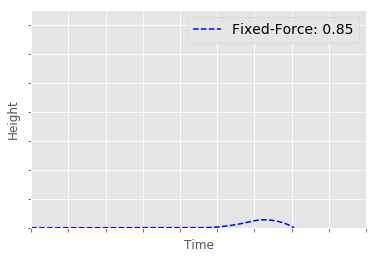

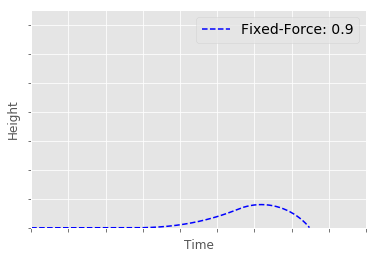

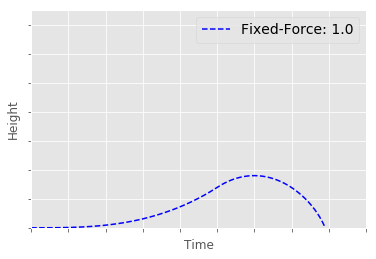

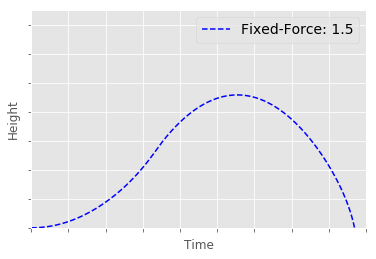

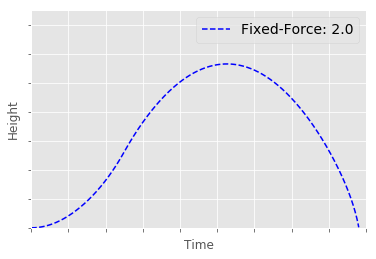

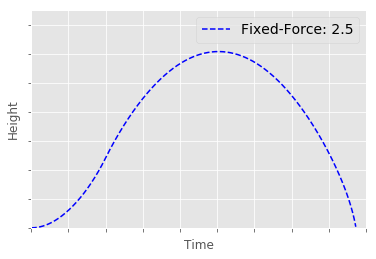

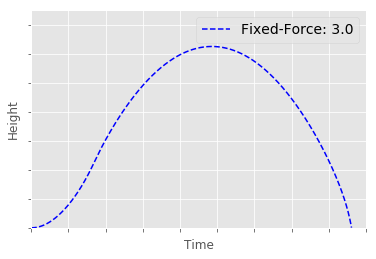

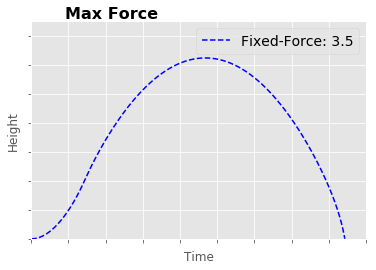

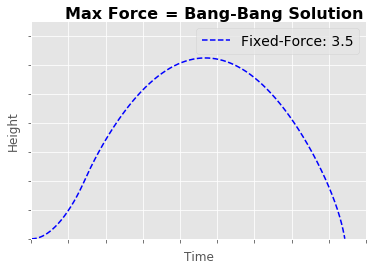

In [95]:
rocket.fixed_force_plots(save=True)

In [25]:
rocket.solve_fixedforce(1)

(array([[  0.00000000e+00,   1.00000000e+00,   1.00000000e+00],
        [  0.00000000e+00,   1.00000000e+00,   9.99600000e-01],
        [  8.00320128e-08,   1.00000000e+00,   9.99200000e-01],
        ..., 
        [ -1.48556142e-01,   1.00007382e+00,   5.99600000e-01],
        [ -1.50955393e-01,   1.00004411e+00,   5.99600000e-01],
        [ -1.53460256e-01,   1.00001392e+00,   5.99600000e-01]]),
 array([1, 1, 1, ..., 0, 0, 0]))

In [849]:
states = rocket.plot_vs()

In [701]:
axes = rocket.plot_vs()
ax=axes[0,0]

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff66d1304a8>


In [674]:
a[0].plot?

Object `plot` not found.


In [ ]:
a[0].plot

In [ ]:
ax.set_xl

In [567]:
rocket.make_fixed_force_movie()

In [10]:
states1, control1 = rocket.solve_bsb()

In [31]:
states2, control2 = rocket.solve_fixedforce(.8)

In [27]:
states2

array([[  0.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [ -2.00000000e-05,   1.00000000e+00,   9.99640000e-01],
       [ -3.99352015e-05,   1.00000000e+00,   9.99280000e-01],
       ..., 
       [ -7.77352887e-02,   1.00004426e+00,   5.99680000e-01],
       [ -7.85463511e-02,   1.00002871e+00,   5.99680000e-01],
       [ -7.93751065e-02,   1.00001300e+00,   5.99680000e-01]])

In [453]:
max(states1[:,1])

1.0127993922979164

In [454]:
max(states2[:,1])

1.012476303306834

In [455]:

100000*(max(states1[:,1]) / max(states2[:,1]))

100031.91077065478

In [456]:
len(control)

351

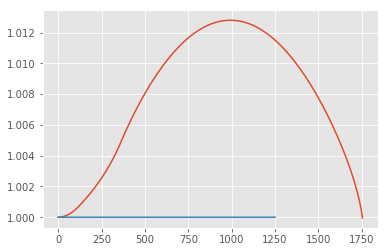

In [32]:
plt.plot(states1[:,1])
plt.plot(states2[:,1])
plt.show()

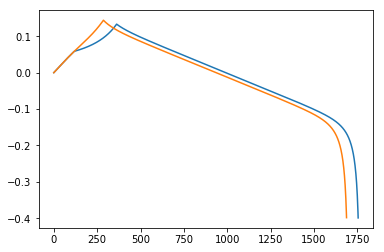

In [458]:
plt.plot(states1[:,0])
plt.plot(states2[:,0])
plt.show()

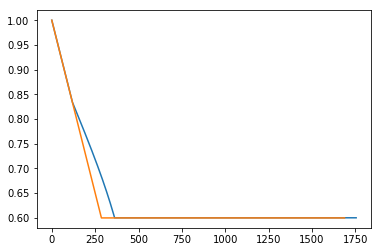

In [459]:
plt.plot(states1[:,2])
plt.plot(states2[:,2])
plt.show()

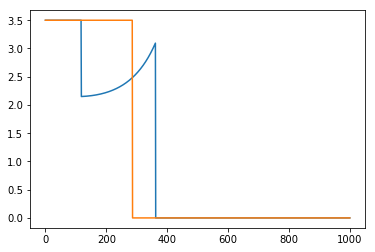

In [461]:
plt.plot(control1[:1000])
plt.plot(control2[:1000])
plt.show()

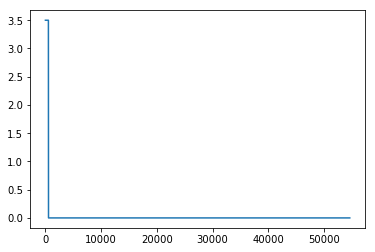

In [359]:
plt.plot(control2)
plt.show()


In [ ]:
#     def solve_fixedforce(self, fixed_force=3.5):
#         i = 0
#         dt = 1/1000
#         states = []
#         control = []
#         state = np.array([self.init_v, self.init_h, self.mass])
        
#         while True:
#             states.append(state)
            
#             if state[2]>=self.dry_mass:
#                 if self.verbose:
#                     print('MAX FORCE')
#                 force = fixed_force
#             else:
#                 force = 0
#             state = self._update(force, state, dt)
#             control.append(force)
            
#             #We ran out of fuel
#             if state[2]<=self.dry_mass:
#                 if self.verbose:
#                     print('RAN OUT OF FUEL')
            
#             if state[1]<=0:
#                 print('CRASH')
#                 break
#             if state[0]<=0:
#                 break
#             #TESTING
#             if i < 10 and state[0]<0:
#                 if self.verbose:
#                     print(f'~~Velocity was negative ({round(state[0],3)}). Setting to 0')
#                 state[0]=0
#             if i>10 and state[1]<=0:
#                 break
#             if self.verbose:
#                 print()
#             if i>5000:
#                 break
                
#         states.append(state)
#         return np.array(states), np.array(control)

In [568]:
%matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro', animated=True)

def init():
    print('init')
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    print(frame)
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

init
0.0
0.049473900056532176
0.09894780011306435
0.14842170016959652
0.1978956002261287
0.2473695002826609
0.29684340033919304
0.3463173003957252
0.3957912004522574
0.4452651005087896
0.4947390005653218
0.5442129006218539
0.5936868006783861
0.6431607007349183
0.6926346007914504
0.7421085008479826
0.7915824009045148


In [494]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
plt.show()

In [495]:
"""
A simple example of an animated plot
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)
plt.show()

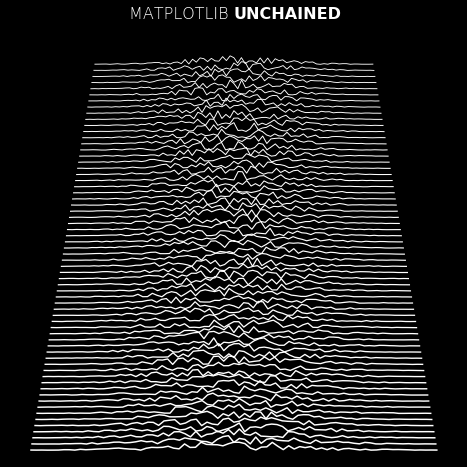

In [62]:
"""
========================
MATPLOTLIB **UNCHAINED**
========================

Comparative path demonstration of frequency from a fake signal of a pulsar.
(mostly known because of the cover for Joy Division's Unknown Pleasures)

Author: Nicolas P. Rougier
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create new Figure with black background
fig = plt.figure(figsize=(8, 8), facecolor='black')

# Add a subplot with no frame
ax = plt.subplot(111, frameon=False)

# Generate random data
data = np.random.uniform(0, 1, (64, 75))
X = np.linspace(-1, 1, data.shape[-1])
G = 1.5 * np.exp(-4 * X * X)

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 200.
    # Same for linewidth (thicker strokes on bottom)
    lw = 1.5 - i / 100.0
    line, = ax.plot(xscale * X, i + G * data[i], color="w", lw=lw)
    lines.append(line)

# Set y limit (or first line is cropped because of thickness)
ax.set_ylim(-1, 70)

# No ticks
ax.set_xticks([])
ax.set_yticks([])

# 2 part titles to get different font weights
ax.text(0.5, 1.0, "MATPLOTLIB ", transform=ax.transAxes,
        ha="right", va="bottom", color="w",
        family="sans-serif", fontweight="light", fontsize=16)
ax.text(0.5, 1.0, "UNCHAINED", transform=ax.transAxes,
        ha="left", va="bottom", color="w",
        family="sans-serif", fontweight="bold", fontsize=16)


def update(*args):
    # Shift all data to the right
    data[:, 1:] = data[:, :-1]

    # Fill-in new values
    data[:, 0] = np.random.uniform(0, 1, len(data))

    # Update data
    for i in range(len(data)):
        lines[i].set_ydata(i + G * data[i])

    # Return modified artists
    return lines

# Construct the animation, using the update function as the animation
# director.
anim = animation.FuncAnimation(fig, update, interval=10)
plt.show()

In [497]:
"""
=================
Animated subplots
=================

This example uses subclassing, but there is no reason that the proper function
couldn't be set up and then use FuncAnimation. The code is long, but not
really complex. The length is due solely to the fact that there are a total of
9 lines that need to be changed for the animation as well as 3 subplots that
need initial set up.

"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation


class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 4)

        self.t = np.linspace(0, 80, 400)
        self.x = np.cos(2 * np.pi * self.t / 10.)
        self.y = np.sin(2 * np.pi * self.t / 10.)
        self.z = 10 * self.t

        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        self.line1 = Line2D([], [], color='black')
        self.line1a = Line2D([], [], color='red', linewidth=2)
        self.line1e = Line2D(
            [], [], color='red', marker='o', markeredgecolor='r')
        ax1.add_line(self.line1)
        ax1.add_line(self.line1a)
        ax1.add_line(self.line1e)
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-2, 2)
        ax1.set_aspect('equal', 'datalim')

        ax2.set_xlabel('y')
        ax2.set_ylabel('z')
        self.line2 = Line2D([], [], color='black')
        self.line2a = Line2D([], [], color='red', linewidth=2)
        self.line2e = Line2D(
            [], [], color='red', marker='o', markeredgecolor='r')
        ax2.add_line(self.line2)
        ax2.add_line(self.line2a)
        ax2.add_line(self.line2e)
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(0, 800)

        ax3.set_xlabel('x')
        ax3.set_ylabel('z')
        self.line3 = Line2D([], [], color='black')
        self.line3a = Line2D([], [], color='red', linewidth=2)
        self.line3e = Line2D(
            [], [], color='red', marker='o', markeredgecolor='r')
        ax3.add_line(self.line3)
        ax3.add_line(self.line3a)
        ax3.add_line(self.line3e)
        ax3.set_xlim(-1, 1)
        ax3.set_ylim(0, 800)

        animation.TimedAnimation.__init__(self, fig, interval=50, blit=True)

    def _draw_frame(self, framedata):
        i = framedata
        head = i - 1
        head_slice = (self.t > self.t[i] - 1.0) & (self.t < self.t[i])

        self.line1.set_data(self.x[:i], self.y[:i])
        self.line1a.set_data(self.x[head_slice], self.y[head_slice])
        self.line1e.set_data(self.x[head], self.y[head])

        self.line2.set_data(self.y[:i], self.z[:i])
        self.line2a.set_data(self.y[head_slice], self.z[head_slice])
        self.line2e.set_data(self.y[head], self.z[head])

        self.line3.set_data(self.x[:i], self.z[:i])
        self.line3a.set_data(self.x[head_slice], self.z[head_slice])
        self.line3e.set_data(self.x[head], self.z[head])

        self._drawn_artists = [self.line1, self.line1a, self.line1e,
                               self.line2, self.line2a, self.line2e,
                               self.line3, self.line3a, self.line3e]

    def new_frame_seq(self):
        return iter(range(self.t.size))

    def _init_draw(self):
        lines = [self.line1, self.line1a, self.line1e,
                 self.line2, self.line2a, self.line2e,
                 self.line3, self.line3a, self.line3e]
        for l in lines:
            l.set_data([], [])

ani = SubplotAnimation()
# ani.save('test_sub.mp4')
plt.show()